<h1>Question 1: Echo Removal from an audio file "goodmorning.wav"</h1>

<h3>IMPORTING RELEVANT LIBRARIES</h3>


In [21]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz
import librosa

<h3>USER DEFINED FUNCTIONS</h3>

In [22]:
def get_window(window, Nx, fftbins=True):
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(Nx) / (Nx - 1))
    

def firwin_custom(numtaps, cutoff, window='hamming', pass_zero=True, scale=True, fs=2):
    nyq = 0.5 * fs
    cutoff = np.atleast_1d(cutoff) / nyq

    pass_nyquist = bool(cutoff.size & 1) ^ pass_zero
    
    cutoff = np.hstack(([0.0] * pass_zero, cutoff, [1.0] * pass_nyquist))
    bands = cutoff.reshape(-1, 2)

    alpha = 0.5 * (numtaps - 1)
    m = np.arange(0, numtaps) - alpha
    h = 0
    for left, right in bands:
        h += right * np.sinc(right * m)
        h -= left * np.sinc(left * m)

    win = get_window(window, numtaps, fftbins=False)
    h *= win

    if scale:
        left, right = bands[0]
        scale_frequency = 0.0 if left == 0 else (1.0 if right == 1 else 0.5 * (left + right))
        c = np.cos(np.pi * m * scale_frequency)
        s = np.sum(h * c)
        h /= s

    return h

def design_pass_band_filter(sampling_rate, lower_freq, upper_freq, num_taps=101):
    nyquist = sampling_rate / 2
    lower = lower_freq / nyquist
    upper = upper_freq / nyquist
    filter_coefficients = firwin_custom(num_taps, [lower, upper], pass_zero=False)
    return filter_coefficients


def convolve_custom(signal, kernel):
    output_length = len(signal) + len(kernel) - 1
    convolved_signal = np.zeros(output_length)
    
    for i in range(output_length):
        for j in range(len(kernel)):
            if i - j >= 0 and i - j < len(signal):
                convolved_signal[i] += signal[i - j] * kernel[j]
    
    return convolved_signal

def apply_filter(signal, filter_coefficients):
    half_kernel = len(filter_coefficients) // 2
    filtered_signal = convolve_custom(signal, filter_coefficients)
    return filtered_signal[half_kernel : -half_kernel]

<h3>READING THE AUDIO FILE AS A NUMPY ARRAY</h3>

In [23]:
signal_not_array, samplerate = librosa.load("goodmorning.wav", sr=44100)
signal = np.array(signal_not_array)

<h3>APPLYING THE FILTER AND WRITING THE FILTERED FILE</h3>

In [24]:
required_frequency_range = [250,2200]
required_frequency_range_1 = [required_frequency_range[0]/2 ,required_frequency_range[1]/2]
sampling_frequency = 44100
filter_order = 1023
filtered_coefficients = design_pass_band_filter(sampling_frequency, required_frequency_range_1[0],required_frequency_range_1[1])
filtered_signal=apply_filter(signal,filtered_coefficients)
sf.write("goodmorning_filtered_.wav", filtered_signal, samplerate)

<h3>COMPARING THE ORIGINAL SIGNAL AND THE FILTERED SIGNAL AMPLITUDE BY PLOTTING BOTH OF THEM</h3>

<p>The red signal is the original signal and the filtered signal is plotted with green color. Both of them are plotted with respect to time</p>

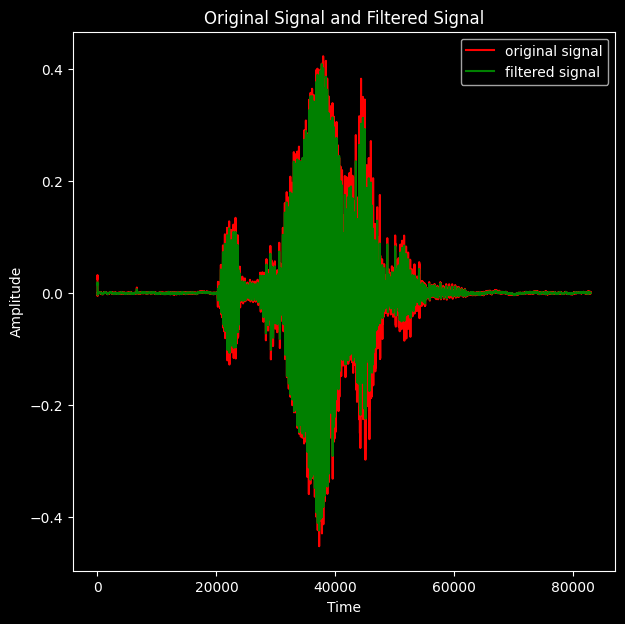

In [25]:
plt.figure(figsize=(7, 7))

plt.title('Original Signal and Filtered Signal')
plt.plot(signal,"r",filtered_signal,"g")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(["original signal", "filtered signal"])
plt.show()



<h3>COMPARING THE FREQUENCY CONTENT OF THE ORIGINAL SIGNAL AND THE FILTERED SIGNAL</h3>

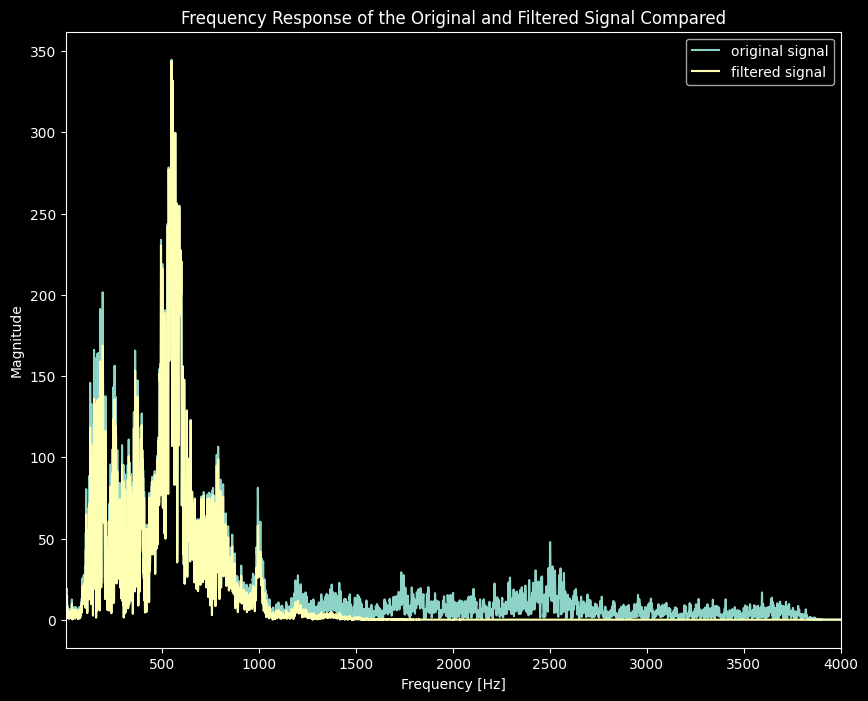

In [26]:
# Plot the regular magnitude response
# sampling_frequency = 8000

plt.figure(figsize=(10, 8))

w_data, h_data = freqz(signal, worN=sampling_frequency)
signal_magnitude_response = np.abs(h_data)
frequencies_hz = w_data * (samplerate / (2 * np.pi))

plt.plot(frequencies_hz, signal_magnitude_response, )

# filtered signal
w_data, h_data = freqz(filtered_signal, worN=sampling_frequency)
filtered_signal_magnitude_response = np.abs(h_data)
frequencies_hz = w_data * (samplerate / (2 * np.pi))

plt.plot(frequencies_hz, filtered_signal_magnitude_response)

plt.title('Frequency Response of the Original and Filtered Signal Compared')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim(1,4000)
plt.legend(["original signal", "filtered signal"])
plt.show()

<h3>FREQUENCY RESPONSE OF THE FILTER</h3>

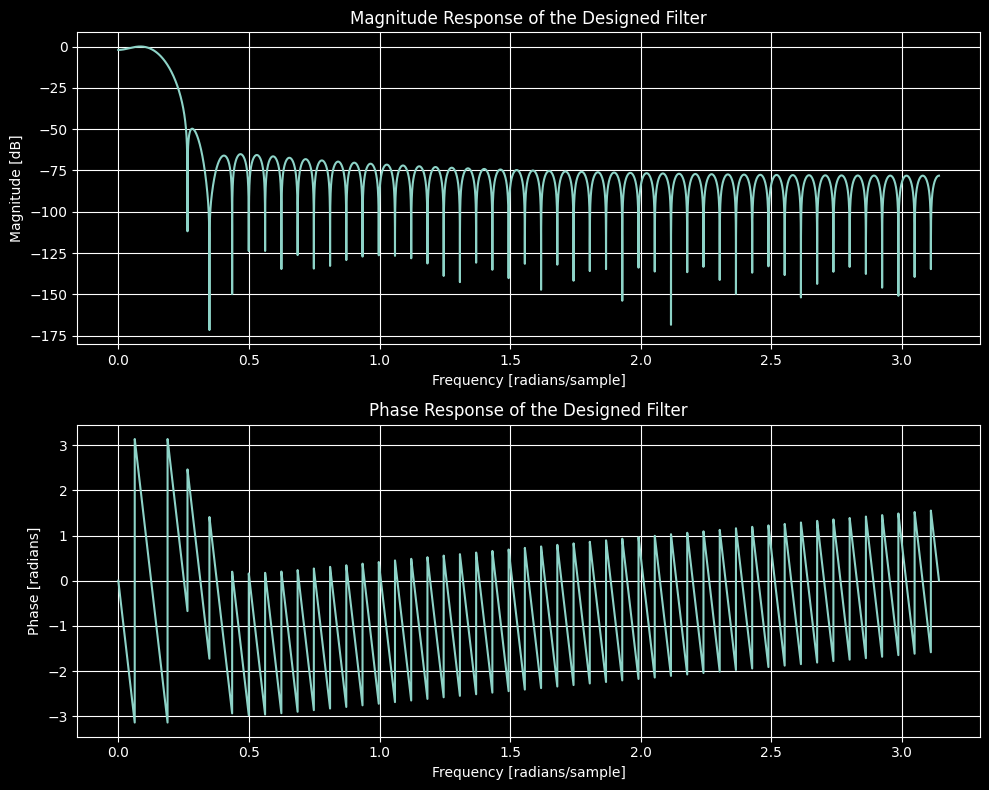

In [27]:
w, h = freqz(filtered_coefficients, worN=sampling_frequency)

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(w, 20 * np.log10(np.abs(h)))
plt.title('Magnitude Response of the Designed Filter')
plt.xlabel('Frequency [radians/sample]')
plt.ylabel('Magnitude [dB]')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(w, np.angle(h))
plt.title('Phase Response of the Designed Filter')
plt.xlabel('Frequency [radians/sample]')
plt.ylabel('Phase [radians]')
plt.grid()

plt.tight_layout()
plt.show()

<h1>Question 2: Separating the Voiced, Unvoiced and Noise components of an audio file "safety.wav"</h1>

<h3>IMPORTING RELEVANT LIBRARIES</h3>

In [28]:
import soundfile as sf
import numpy as np
from scipy.signal import freqz
import matplotlib.pyplot as plt
import librosa

<h3>USER DEFINED FUNCTIONS</h3>

In [29]:
def sinc(x):
    result = np.where(x == 0, 1.0, np.sin(np.pi * x) / (np.pi * x))
    result[np.isnan(result)] = 1.0  # Set the values where division by zero occurred to 1.0
    return result

def get_window(window, Nx, fftbins=True):
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(Nx) / (Nx - 1))
   

def firwin_custom(numtaps, cutoff, window='hamming', pass_zero=True, scale=True, fs=2):
    nyq = 0.5 * fs
    cutoff = np.atleast_1d(cutoff) / nyq

    pass_nyquist = bool(cutoff.size & 1) ^ pass_zero
   
    cutoff = np.hstack(([0.0] * pass_zero, cutoff, [1.0] * pass_nyquist))
    bands = cutoff.reshape(-1, 2)

    alpha = 0.5 * (numtaps - 1)
    m = np.arange(0, numtaps) - alpha
    h = 0
    for left, right in bands:
        h += right * sinc(right * m)
        h -= left * sinc(left * m)

    win = get_window(window, numtaps, fftbins=False)
    h *= win

    if scale:
        left, right = bands[0]
        scale_frequency = 0.0 if left == 0 else (1.0 if right == 1 else 0.5 * (left + right))
        c = np.cos(np.pi * m * scale_frequency)
        s = np.sum(h * c)
        h /= s

    return h

# Function to design a pass-band filter
def design_pass_band_filter(sampling_rate, lower_freq, upper_freq, num_taps=101):
    nyquist = sampling_rate / 2
    lower = lower_freq / nyquist
    upper = upper_freq / nyquist
    filter_coefficients = firwin_custom(num_taps, [lower, upper], pass_zero=False)
    return filter_coefficients


def convolve_custom(signal, kernel):
    output_length = len(signal) + len(kernel) - 1
    convolved_signal = np.zeros(output_length)
    
    for i in range(output_length):
        for j in range(len(kernel)):
            if i - j >= 0 and i - j < len(signal):
                convolved_signal[i] += signal[i - j] * kernel[j]
    
    return convolved_signal

def apply_filter(signal, filter_coefficients):
    half_kernel = len(filter_coefficients) // 2
    filtered_signal = convolve_custom(signal, filter_coefficients)
    return filtered_signal[half_kernel : -half_kernel]

import numpy as np
import matplotlib.pyplot as plt

def compute_psd(signal, sample_rate, window_size):

    num_segments = int(len(signal) / window_size + 1)
    segment_length = int(window_size)

    psd_values = np.zeros((num_segments, int(segment_length / 2) + 1))
    frequencies = np.linspace(0, sample_rate / 2, int(segment_length / 2) + 1)

    for segment_idx in range(num_segments):
        start_idx = int(segment_idx * (window_size))
        end_idx = start_idx + segment_length

        signal_segment = signal[start_idx:end_idx]
        segment_fft = np.fft.fft(signal_segment, segment_length)
        psd_segment = np.abs(segment_fft) ** 2

        psd_segment /= segment_length

        psd_values[segment_idx] = psd_segment[:int(segment_length / 2) + 1]

    return psd_values, frequencies

def plot_psd(psd_values, frequencies, title ):

    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, 20 * np.log10(np.mean(psd_values, axis=0)))

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (dB/Hz)')
    plt.title(title)

    plt.show()

<h3>READING THE AUDIO FILE AS A NUMPY ARRAY</h3>

In [30]:
signal_not_array, samplerate = sf.read("safety.wav")
signal = np.array(signal_not_array)

<h3>PLOTTING THE ORIGINAL SIGNAL'S TIME AND FREQUENCY RESPONSES</h3>

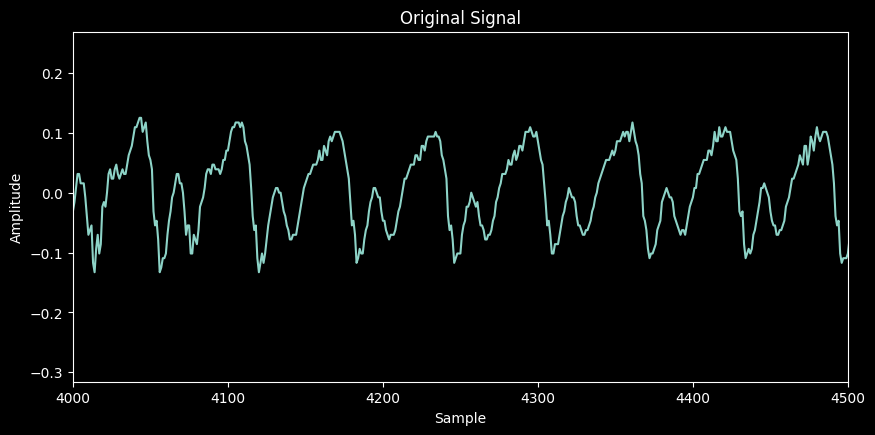

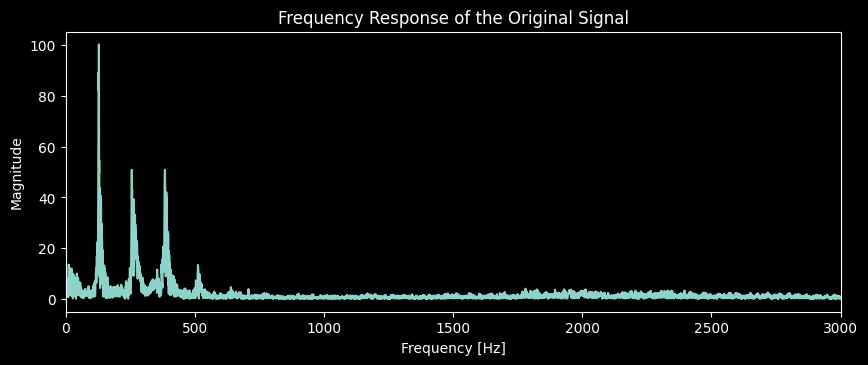

In [31]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.title('Original Signal')
plt.plot(signal)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.xlim(4000,4500)

w_data, h_data = freqz(signal, worN=8000)

signal_magnitude_response = np.abs(h_data)

frequencies_hz = w_data * (samplerate / (2 * np.pi))

plt.figure(figsize=(10, 8))

# Plot the regular magnitude response
plt.subplot(2, 1, 2)
plt.plot(frequencies_hz, signal_magnitude_response)
plt.title('Frequency Response of the Original Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim(0,3000)

plt.show()

<ul>Characteristics of the Original Signal: 
    <li>The signal is non periodic</li>
    <li>It has significant amount of background noise</li>
    <li>The highest amplitude which corresponds to the voiced signal is limited to the range 0 to 850 Hz</li>
    <li>The highest amplitude which corresponds to the unvoiced signal is limited to the range 950 to 1050 Hz</li>
    <li>The highest amplitude which corresponds to the backround noise is beyond 1051 Hz</li>
</ul>

<h4>The corresponding filters are designed subsequently</h4>

<h3>APPLYING THE FILTER TO THE ORIGINAL SIGNAL TO GET THE VOICED COMPONENT</h3>

In [32]:
required_frequency_range = [1,850]
required_frequency_range_1 = [required_frequency_range[0]/2 ,required_frequency_range[1]/2]
sampling_frequency = 8000
filter_order = 101

filter_coefficients_for_voiced = design_pass_band_filter(samplerate, required_frequency_range_1[0], required_frequency_range_1[1])

filtered_signal_safety_speech = apply_filter(signal, filter_coefficients_for_voiced)

sf.write("safety_speech.wav", filtered_signal_safety_speech, samplerate)

C:\Users\lakshit\AppData\Local\Temp\ipykernel_25088\1311072089.py:2: RuntimeWarning: invalid value encountered in divide
  result = np.where(x == 0, 1.0, np.sin(np.pi * x) / (np.pi * x))


<h3>APPLYING THE FILTER TO THE ORIGINAL SIGNAL TO GET THE UNVOICED COMPONENT</h3>

In [33]:
required_frequency_range = [950,1050]
required_frequency_range_1 = [required_frequency_range[0]/2 ,required_frequency_range[1]/2]
sampling_frequency = 8000
filter_order = 101

filter_coefficients_for_unvoiced = design_pass_band_filter(samplerate, required_frequency_range_1[0], required_frequency_range_1[1])

filtered_signal_safety_unspeeched = apply_filter(signal, filter_coefficients_for_unvoiced)

sf.write("safety_unspeeched.wav", filtered_signal_safety_unspeeched*2, samplerate)

C:\Users\lakshit\AppData\Local\Temp\ipykernel_25088\1311072089.py:2: RuntimeWarning: invalid value encountered in divide
  result = np.where(x == 0, 1.0, np.sin(np.pi * x) / (np.pi * x))


<h3>APPLYING THE FILTER TO THE ORIGINAL SIGNAL TO GET THE NOISE</h3>
<p>Note: The noise is beyond 1051 Hz, but for analysis purpose a small range is enough. So we have designed a band pass filter</p>

In [34]:
required_frequency_range = [1051,3000]
required_frequency_range_1 = [required_frequency_range[0]/2 ,required_frequency_range[1]/2]
sampling_frequency = 8000
filter_order = 101

filter_coefficients_for_noise = design_pass_band_filter(samplerate, required_frequency_range_1[0], required_frequency_range_1[1])

filtered_signal_safety_noise = apply_filter(signal, filter_coefficients_for_noise)

sf.write("safety_noise.wav", filtered_signal_safety_noise*4, samplerate)

C:\Users\lakshit\AppData\Local\Temp\ipykernel_25088\1311072089.py:2: RuntimeWarning: invalid value encountered in divide
  result = np.where(x == 0, 1.0, np.sin(np.pi * x) / (np.pi * x))


<h3>PLOTTING THE RELEVANT RESPONSES OF THE COMPONENTS AND THE FILTERS USED TO GET THEM</h3>

<h4>Voiced Signal</h4>

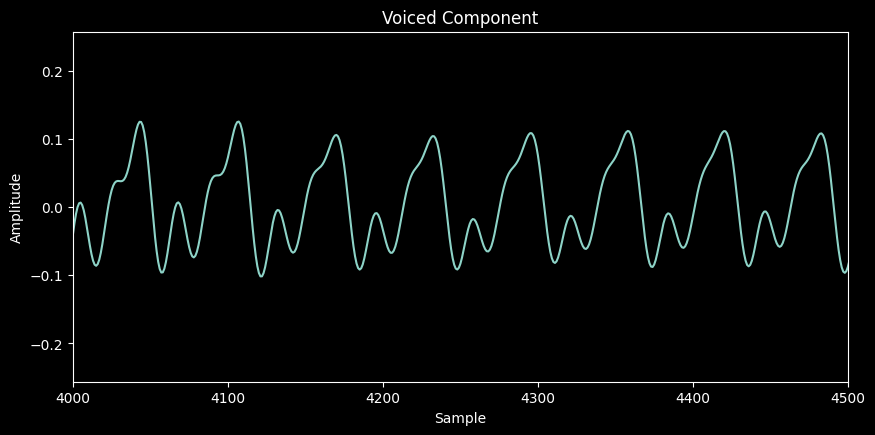

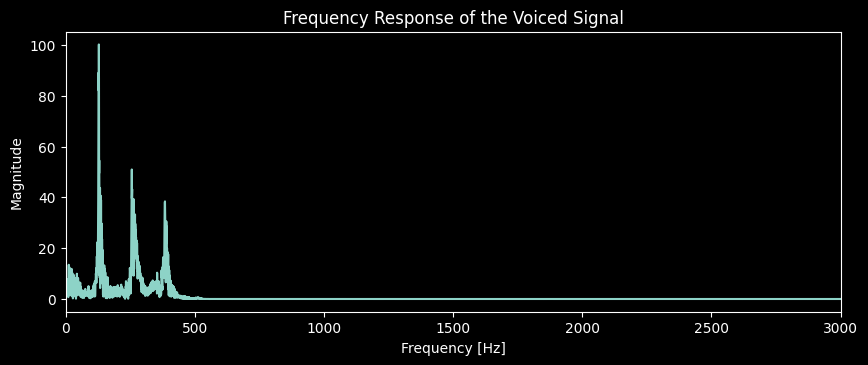

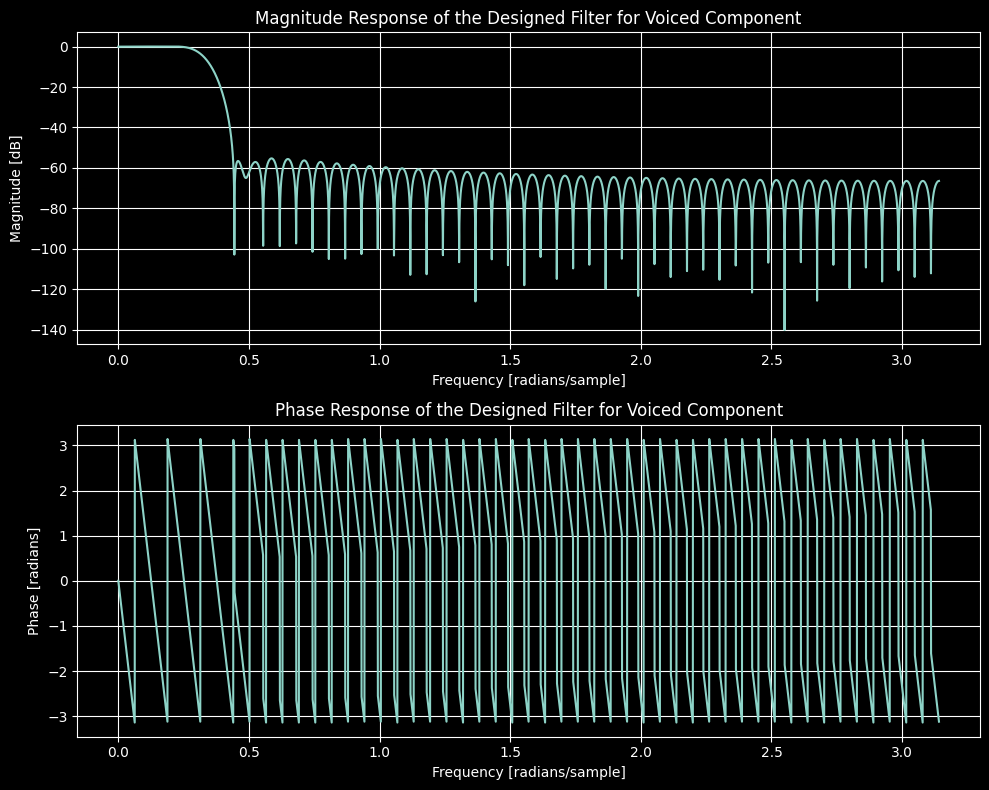

In [35]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.title('Voiced Component')
plt.plot(filtered_signal_safety_speech)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.xlim(4000,4500)

w_data, h_data = freqz(filtered_signal_safety_speech, worN=8000)

signal_magnitude_response = np.abs(h_data)

frequencies_hz = w_data * (samplerate / (2 * np.pi))

plt.figure(figsize=(10, 8))

# Plot the regular magnitude response
plt.subplot(2, 1, 2)
plt.plot(frequencies_hz, signal_magnitude_response)
plt.title('Frequency Response of the Voiced Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim(0,3000)

plt.show()

w, h = freqz(filter_coefficients_for_voiced, worN=8000)

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(w, 20 * np.log10(np.abs(h)))
plt.title('Magnitude Response of the Designed Filter for Voiced Component')
plt.xlabel('Frequency [radians/sample]')
plt.ylabel('Magnitude [dB]')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(w, np.angle(h))
plt.title('Phase Response of the Designed Filter for Voiced Component')
plt.xlabel('Frequency [radians/sample]')
plt.ylabel('Phase [radians]')
plt.grid()

plt.tight_layout()
plt.show()

<ul>Characteristics of the Voiced Signal
    <li>The voiced component is periodic in nature, as it should be.</li>
    <li>The voiced component is noise free.</li>
</ul>

<h4>Unvoiced Signal</h4>

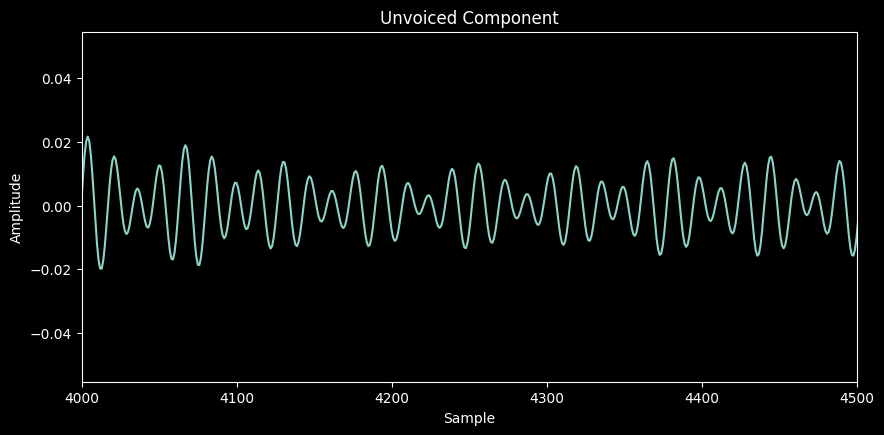

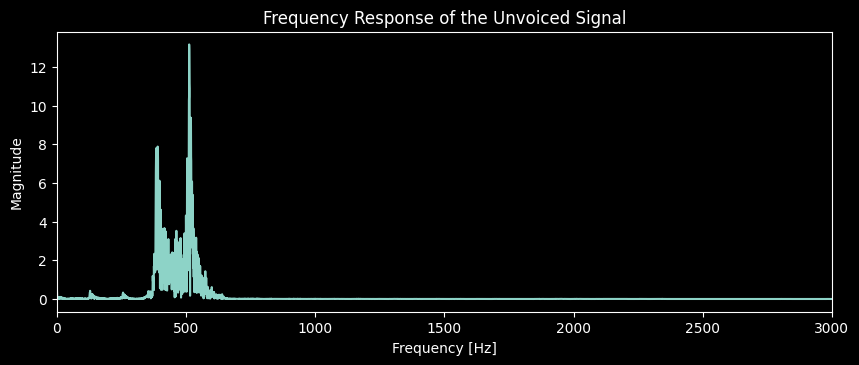

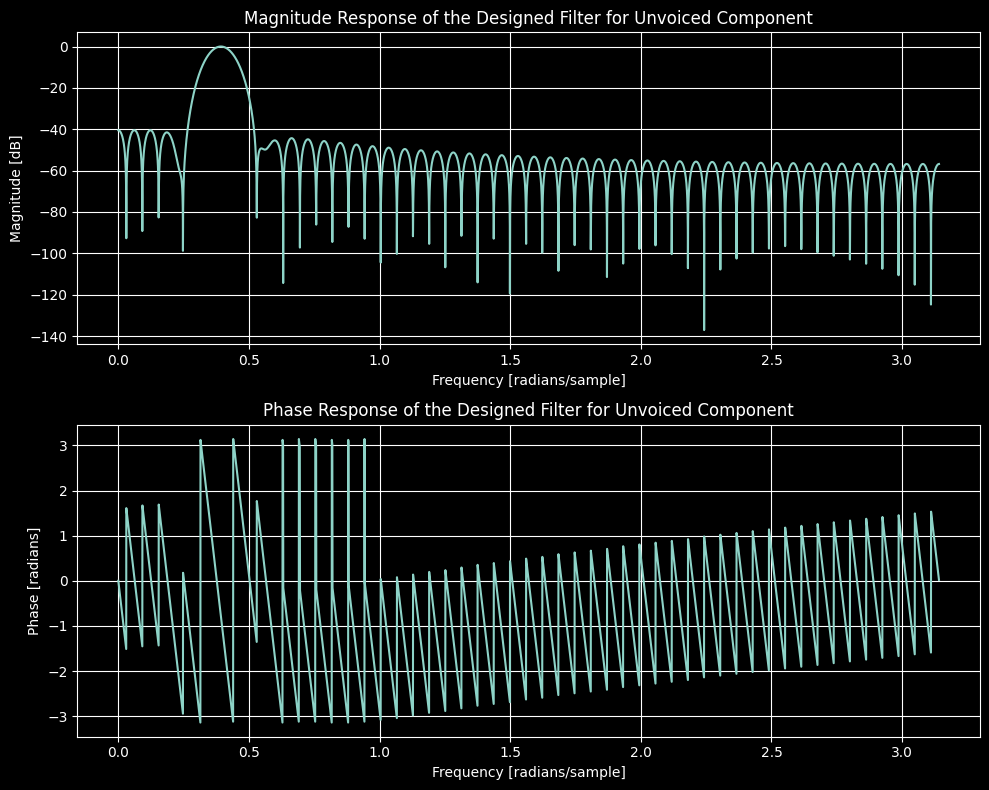

In [36]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.title('Unvoiced Component')
plt.plot(filtered_signal_safety_unspeeched)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.xlim(4000,4500)

w_data, h_data = freqz(filtered_signal_safety_unspeeched, worN=8000)

signal_magnitude_response = np.abs(h_data)

frequencies_hz = w_data * (samplerate / (2 * np.pi))

plt.figure(figsize=(10, 8))

# Plot the regular magnitude response
plt.subplot(2, 1, 2)
plt.plot(frequencies_hz, signal_magnitude_response)
plt.title('Frequency Response of the Unvoiced Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim(0,3000)

plt.show()

w, h = freqz(filter_coefficients_for_unvoiced, worN=8000)

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(w, 20 * np.log10(np.abs(h)))
plt.title('Magnitude Response of the Designed Filter for Unvoiced Component')
plt.xlabel('Frequency [radians/sample]')
plt.ylabel('Magnitude [dB]')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(w, np.angle(h))
plt.title('Phase Response of the Designed Filter for Unvoiced Component')
plt.xlabel('Frequency [radians/sample]')
plt.ylabel('Phase [radians]')
plt.grid()

plt.tight_layout()
plt.show()

<ul>Characteristics of Unvoiced signal
    <li>The unvoiced component is very small as compared to the voiced signal, which can be verified by hearing the audio as well.</li>
    <li>The unvoiced component is noise free.</li>
</ul>

<h3>Noise Component</h3>

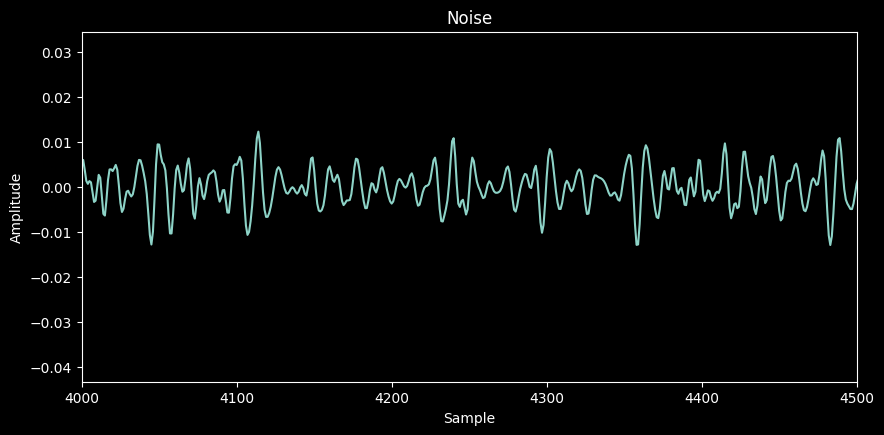

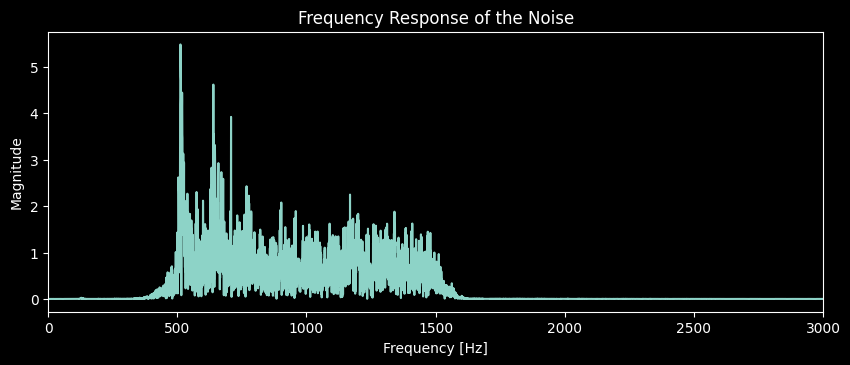

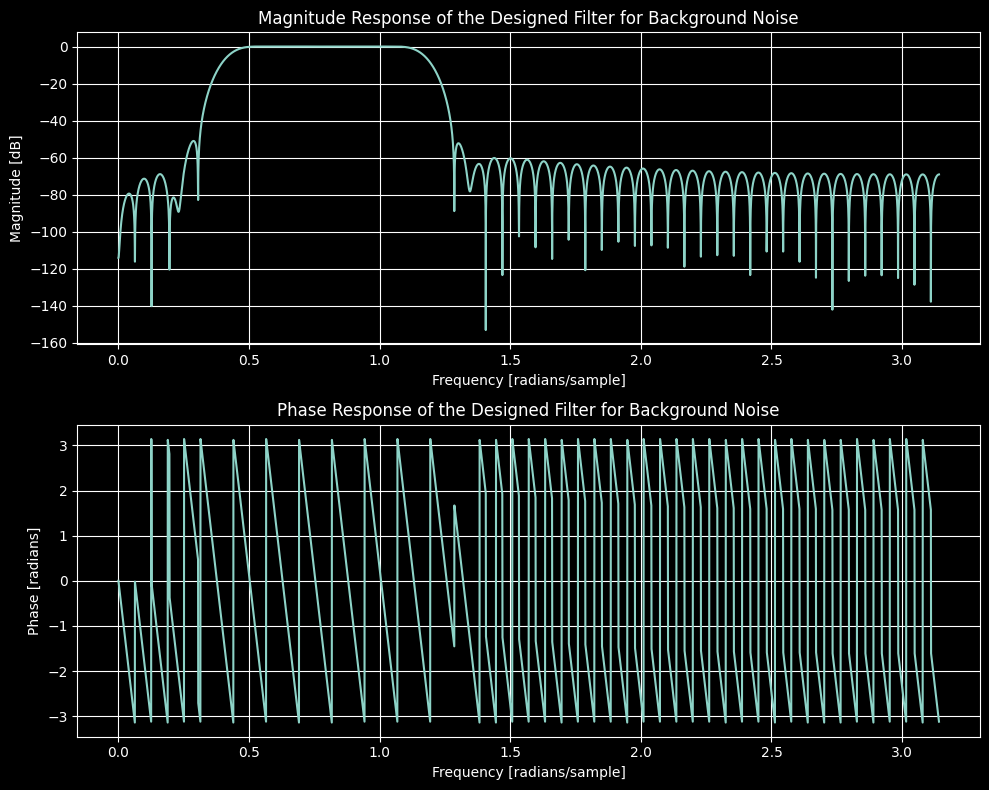

In [37]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.title('Noise')
plt.plot(filtered_signal_safety_noise)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.xlim(4000,4500)

w_data, h_data = freqz(filtered_signal_safety_noise, worN=8000)

signal_magnitude_response = np.abs(h_data)

frequencies_hz = w_data * (samplerate / (2 * np.pi))

plt.figure(figsize=(10, 8))

# Plot the regular magnitude response
plt.subplot(2, 1, 2)
plt.plot(frequencies_hz, signal_magnitude_response)
plt.title('Frequency Response of the Noise')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim(0,3000)

plt.show()

w, h = freqz(filter_coefficients_for_noise, worN=8000)

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(w, 20 * np.log10(np.abs(h)))
plt.title('Magnitude Response of the Designed Filter for Background Noise')
plt.xlabel('Frequency [radians/sample]')
plt.ylabel('Magnitude [dB]')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(w, np.angle(h))
plt.title('Phase Response of the Designed Filter for Background Noise')
plt.xlabel('Frequency [radians/sample]')
plt.ylabel('Phase [radians]')
plt.grid()

plt.tight_layout()
plt.show()

<ul>Characteristics of the Noise component
    <li>The noise component is comparable to the unvoiced component in terms of magnitude, thereby making it difficult to distinguish between the two.</li>
    <li>The noise component is random, which was expected.</li>
</ul>

<h1>Plotting PSD</h1>

<h4>Voiced Component</h4>

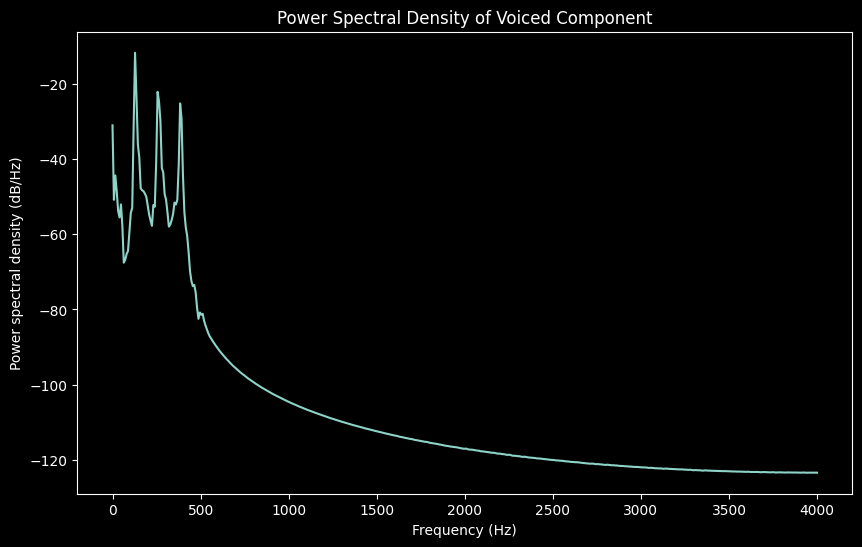

In [38]:
window_size = 1000
overlap = 0

psd_values, frequencies = compute_psd(filtered_signal_safety_speech, samplerate, window_size)

plot_psd(psd_values, frequencies, "Power Spectral Density of Voiced Component")

<h4>Unvoiced Component</h4>

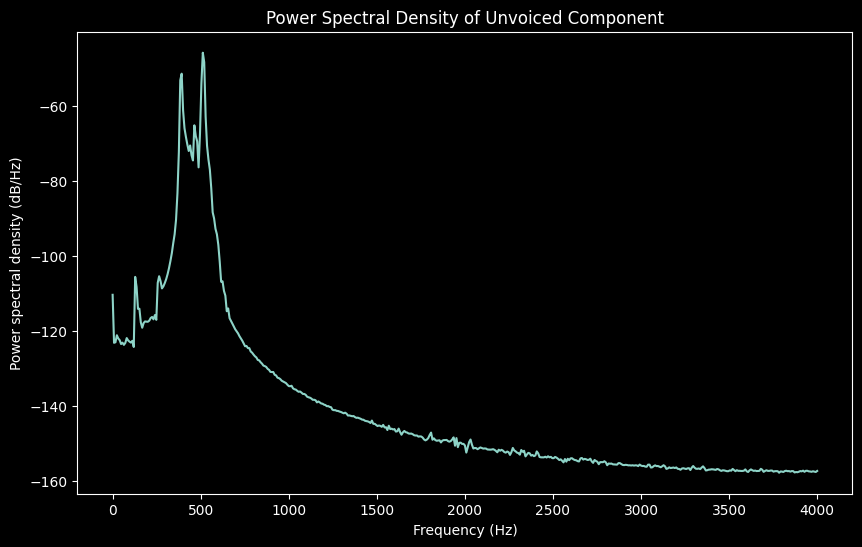

In [39]:
window_size = 1000
overlap = 0

psd_values, frequencies = compute_psd(filtered_signal_safety_unspeeched, samplerate, window_size)

plot_psd(psd_values, frequencies, "Power Spectral Density of Unvoiced Component")

<h4>Noise Component</h4>

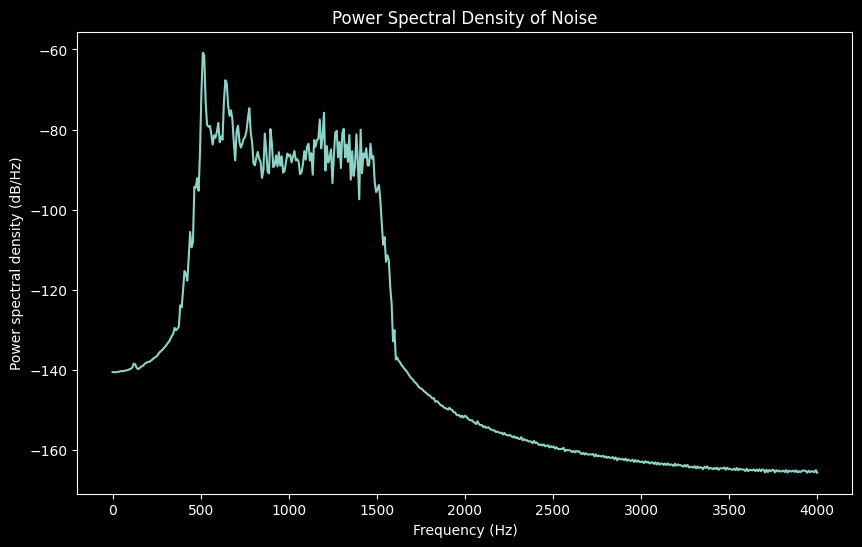

In [40]:
window_size = 1000
overlap = 0

psd_values, frequencies = compute_psd(filtered_signal_safety_noise, samplerate, window_size)

plot_psd(psd_values, frequencies, "Power Spectral Density of Noise")